# Algoritmo Genetico per la risoluzione del problema del Capacitated Vehicle Routing with Time Window

L’algoritmo simula l’evoluzione di una popolazione (dove ogni individuo è una soluzione) attraverso l’uso di operatori genetici che permettono la trasmissione e la mutazione del contenuto informativo . L’evoluzione termina quando le soluzioni della popolazione assumono una fitness molto simile. L’algoritmo prevede una popolazione iniziale la quale consiste in un insieme di soluzioni ammissibili generate a partire da un’euristica o casualmente. In un problema CVRPTW non è possibile generare casualmente tutte soluzioni ammissibili pertanto si è scelto di usare un’euristica.

La codifica del problema è stata eseguita nel seguente modo: ogni soluzione è rappresentata da una stringa di K elementi ordinati secondo il verso di percorrenza, dove K è pari al numero di nodi più il numero di camion impiegati nella soluzione. Nella stringa ogni elemento può assumere un valore tra 0 e N-1, escluso il deposito (valore 0) ogni valore si presenta nella stringa una sola volta, mentre il valore 0 si ripete ad ogni inizio e fine di percorso. Un esempio è il seguente:

\begin{equation}
[0 1 4 5 0 6 8 3 2 0 7 9 0]
\end{equation}


### Funzioni di supporto per un nodo

In [12]:
import gurobipy as gb
from gurobipy import *
import re
import math
import matplotlib.pyplot as plt
import networkx as nx

# Calcolo della distanza tra due nodi
def distance(node1, node2):
    i = node1["coordinate"]
    j = node2["coordinate"]
    diff = (i[0] - j[0], i[1] - j[1])
    return math.sqrt(diff[0] * diff[0] + diff[1] * diff[1])

# Calcolo del tempo di viaggio tra due nodi
def travel_time(node1, node2):
    return round(distance(node1,node2), 1)

# Funzione di print per i nodi
def print_N(node):
    return "\n" + "Numero nodo: " + str(node["number"]) + "\n" + "Coordinate: " + str(node["coordinate"]) + "\n" + "Domanda: " + str(node["demand"]) + "\n" + "Ready Time: " + str(node["rdy_time"]) + "\n" + "Due Date: " + str(node["due_date"]) + "\n" + "Service Time: " + str(node["service_time"])


### Funzioni di supporto per il modello CVRPTW

In [13]:
# Calcola della matrice delle distanze: matrice in cui l'elemento (i,j) indica la distanza tra il nodi i-esimo e il nodo j-esimo
def distance_matrix(problem):
    problem["d_matrix"] = {(i,j): distance(problem["nodes"][i], problem["nodes"][j]) for i in range(problem["nodes_num"]) for j in range(problem["nodes_num"]) if i != j}

# Calcola della matrice dei tempi di viaggio: matrice in cui l'elemento (i,j) indica il tempo di viaggio tra il nodi i-esimo e il nodo j-esimo
def travel_matrix(problem):
    problem["t_matrix"] = {(i,j): round(problem["d_matrix"][i, j], 1) for i in range(problem["nodes_num"]) for j in range(problem["nodes_num"]) if i != j}

# Lettura e inizializzazione del modello
def read_file(file):
    nodes_num = 0 # Numero di nodi
    nodes = [] # Lista di nodi

    f = open(file, "r")
    line = f.readline()
    line.strip("\n")
    name_istance = line

    for i in range (3):
        line = f.readline() # Salto 3 linee
    
    line = f.readline()
    data = re.findall(r"[-+]?\d.\d+|\d+", line)
    num_vh = int(data[0])
    capacity = int(data[1])  

    for i in range (4):
        line = f.readline() # Salto 4 linee

    line = f.readline()
    while not line.startswith("EOF"):
        data = re.findall(r"[-+]?\d.\d+|\d+", line)
        coordinate = (int(data[1]), int(data[2]))
        demand = int(data[3])
        rdy_time = int(data[4])
        due_date = int(data[5])
        serv_time = int(data[6])
        nodes.append({"number": nodes_num, "coordinate": coordinate, "demand": demand, "rdy_time": rdy_time, "due_date": due_date, "service_time": serv_time})
        nodes_num += 1
        line = f.readline()
    f.close()

    problem = {"nodes_num": nodes_num , "nodes": nodes, "name_instance": name_istance, "num_veh": num_vh, "capacity": capacity, "d_matrix": [] , "t_matrix": [] , "routes": []}

    distance_matrix(problem)
    travel_matrix(problem)

    return problem

# Funzione di print per l'istanza
def print_P(problem):
    print("Nome istanza: " + str(problem["name_instance"]))
    print("Numero nodi: " + str(problem["nodes_num"]))
    print("Max Veicoli: " + str(problem["num_veh"]))
    print("Capacità veicoli: " + str(problem["capacity"]))         
    

### Funzioni di supporto per l'algoritmo genetico

In [14]:
import numpy as np
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import time
import random
from random import choice
from random import seed

# Calcola il valore della funzione obbiettivo dalla matrice delle distanze
def calculate_obj_fun_value(solution, d_matrix):
    obj_fun_value = 0
    for n in range(len(solution["routes"]) - 1):
        if solution["routes"][n]["number"] != solution["routes"][n+1]["number"]:
            obj_fun_value += d_matrix[solution["routes"][n]["number"], solution["routes"][n+1]["number"]]
    return obj_fun_value

# Aggiunge il deposito (nodo 0) ai percorsi e ricalcola la fitness
def add_storage(solution):
    current_time = 0
    truck_number = 0
    current_node = 0
    solution["routes"].insert(current_node, solution["problem"]["nodes"][0])
    remaining_capacity = solution["problem"]["capacity"]
    nodes_checked_count = 0

    i = 1
    # Per ogni nodo
    while nodes_checked_count < solution["problem"]["nodes_num"] - 1:
        # Current_node inizalmente simboleggia un deposito fittizzio
        # next_node -> nodo successivo da visitare
        next_node = solution["routes"][i]

        
        # Verifica i vincoli di capacità e temporali
        if next_node["demand"] <= remaining_capacity and (current_time + solution["problem"]["t_matrix"][current_node, next_node["number"]]) <= next_node["due_date"]:
            remaining_capacity = remaining_capacity - next_node["demand"]
            if (current_time + solution["problem"]["t_matrix"][current_node, next_node["number"]]) <= next_node["rdy_time"]:
                current_time = next_node["rdy_time"] + next_node["service_time"]
            else:
                current_time = current_time + solution["problem"]["t_matrix"][current_node, next_node["number"]] + next_node["service_time"]
            # Se i vincoli sono rispettati passo al nodo successivo
            current_node = next_node["number"]
            i += 1
            nodes_checked_count += 1
        # Altrimenti significa che sono giunto al deposito e il veicolo ha terminato la sua tratta
        else:
            truck_number += 1                                                       # Incremento il numero di veicoli utilizzati 
            solution["routes"].insert(i, solution["problem"]["nodes"][0])           # Inserisco il deposito
            current_time = 0                                                        # Resetto il tempo impiegato dal veicolo per compiere la tratta
            i += 1                                                                  # Passo al nodo successivo
            remaining_capacity = solution["problem"]["capacity"]                    # Resetto la capacità
            current_node = 0                                                        # Nuovo deposito fittizzio

    # Condizione di ammissibilità = numero di camion minore al numero consentito
    solution["routes"].append(solution["problem"]["nodes"][0])
    truck_number += 1
    solution["truck_count"] = truck_number
    solution["obj_fun_value"] = calculate_obj_fun_value(solution, solution["problem"]["d_matrix"])
    solution["admissible"] = check_admissible(solution)
    solution["fitness"] = 1/solution["obj_fun_value"]
    
    return 0

# Inizializza la soluzione (crea un dizionario rappresentante la soluzione)
def init_sol(routes, problem, trucks = 0):
    solution =  {"problem": problem, "routes": routes, "truck_count": trucks, "obj_fun_value": 0, "admissible": 0, "fitness": 0}
    solution["obj_fun_value"] = calculate_obj_fun_value(solution, problem["d_matrix"])
    solution["admissible"] = check_admissible(solution)
    solution["fitness"] = 1/solution["obj_fun_value"]

    return solution

# Verifica l'ammissibilità della soluzione
def check_admissible(solution):
    if solution["truck_count"] <= solution["problem"]["num_veh"]:
        admissible = 1
    else:
        admissible = 0
        # Aggiungo un fattore di penalità alla funzione obbiettivo
        solution["obj_fun_value"] += 300 * (solution["truck_count"] - solution["problem"]["num_veh"])

    return admissible

# Funzione di print per la soluzione
def print_S(solution):
    print("Routes : ")
    for i in range(len(solution["routes"])):
        if i == 0 or solution["routes"][i]["number"] != 0:
            print(solution["routes"][i]["number"], end=" , ")
        else:
            print("0")
    print("Valore funzione obbiettivo: " + str(solution["obj_fun_value"]))
    print("Numero Camion: " + str(solution["truck_count"]))
    print("Ammissibile :" + str(solution["admissible"]))

# Funzione che effettua la copia della soluzione
def copy_S(solution, solution_to_copy):
    solution["problem"] = solution_to_copy["problem"]
    solution["routes"] = solution_to_copy["routes"][0: len(solution_to_copy["routes"])]
    solution["truck_count"] = solution_to_copy["truck_count"]
    solution["obj_fun_value"] = solution_to_copy["obj_fun_value"]
    solution["fitness"] = solution_to_copy["fitness"]
    solution["admissible"] = solution_to_copy["admissible"]

# Estrazione delle due soluzioni peggiori
def two_worst_solution(GA):
    fitness = []
    for i in GA["population"]:
        fitness.append(i["fitness"])
    arg_sort = np.argsort(fitness) # Ritorno gli indici delle due soluzioni peggiori
    return arg_sort[0], arg_sort[1]

# Estrazione della soluzione peggiore
def worst_solution(GA):
    return max(GA["population"], key=lambda item: item["obj_fun_value"])

# Estrazione della soluzione migliore
def best_solution(GA):
    return min(GA["population"], key=lambda item: item["obj_fun_value"])

# Aggiornamento della popolazione con le due nuove soluzioni
def update_population(GA, index_old_sol_1, index_old_sol_2, new_sol_1, new_sol_2):
    if GA["population"][index_old_sol_1]["fitness"] > GA["population"][index_old_sol_2]["fitness"]:
        index_worst_old = index_old_sol_2
        index_best_old = index_old_sol_1
    else:
        index_worst_old = index_old_sol_1
        index_best_old = index_old_sol_2
    
    if new_sol_1["fitness"] > new_sol_2["fitness"]:
        best_new = new_sol_1
        worst_new = new_sol_2
    else:
        best_new = new_sol_2
        worst_new = new_sol_1
    
    if best_new["fitness"] <= GA["population"][index_worst_old]["fitness"]:
        return 0
    else:
        if best_new["fitness"] > GA["population"][index_best_old]["fitness"] and worst_new["fitness"] > GA["population"][index_worst_old]["fitness"]:
            if index_best_old > index_worst_old:
                GA["population"].remove(GA["population"][index_best_old])
                GA["population"].remove(GA["population"][index_worst_old])
            else:
                GA["population"].remove(GA["population"][index_worst_old])
                GA["population"].remove(GA["population"][index_best_old])
            
            GA["population"].append(best_new)
            GA["population"].append(worst_new)
        else:
            GA["population"].remove(GA["population"][index_worst_old])
            GA["population"].append(best_new)
        return 0

# Funzione di stampa per la rappresentazione della soluzione
def graph_solution(GA, solution):
    Graph = nx.DiGraph()
    list_nodes = list(range(GA["problem"]["nodes_num"]))
    Graph.add_nodes_from(list_nodes)
    for i in range(len(solution["routes"]) - 1):
        Graph.add_edge(solution["routes"][i]["number"], solution["routes"][i+1]["number"])

    coordinates = {}
    for i in range(GA["problem"]["nodes_num"]):
        coordinates[i] = GA["problem"]["nodes"][i]["coordinate"]

    nx.draw_networkx(Graph, coordinates, font_size=8, font_color='k', node_color='green', edgecolors='k', node_size=300)
    nx.draw_networkx_edges(Graph, coordinates, arrowsize=7, arrowstyle='->', edge_color='black')

    plt.show()

# Calcolo del gap
def gap_calculation(file, obj_fun_value):

    best_val = [191.3, 827.3, 2707.9, 7152.02, 14095.64]

    def gap_formulation(val1, val2):
        return (abs(val1 - val2)/val1) * 100
    
    if file == "./Desktop/RO_progetto/Dataset/Solomon/25/C101.txt":
        return gap_formulation(best_val[0], obj_fun_value)
    elif file == "./Desktop/RO_progetto/Dataset/Solomon/100/C101.txt":
        return gap_formulation(best_val[1], obj_fun_value)
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_2_1.TXT":
        return gap_formulation(best_val[2], obj_fun_value)
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_4_1.TXT":
        return gap_formulation(best_val[3], obj_fun_value)
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_6_1.TXT":
        return gap_formulation(best_val[4], obj_fun_value)

# Calcolo limit euristiche
def parameter_calculation(file):

    if file == "./Desktop/RO_progetto/Dataset/Solomon/25/C101.txt":
        return 10, 0.01, 3
    elif file == "./Desktop/RO_progetto/Dataset/Solomon/100/C101.txt":
        return 10, 0.01, 10
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_2_1.TXT":
        return 10, 0.01, 40
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_4_1.TXT":
        return 10, 0.2, 15
    elif file == "./Desktop/RO_progetto/Dataset/Homberger/C1_6_1.TXT":
        return 15, 0.1, 10


### Generazione soluzione iniziale

Per la generazione della popolazione è stata implementata un'euristica con un certo fattore di casualità. Tale euristica viene eseguite un numero di volte arbitrario generando così una popolazione inziale. 

In aggiunta al criterio scelto per la selezione è stato inserito anche un fattore randomico per il quale dopo ogni tot nodi analizzati ne viene scelto uno casualmente 

#### Algoritmo


L'algirtmo costruisce la soluzione partendo dal deposito e aggiungendo un nodo alla volta al percorso. La scelta del nodo da aggiungere può ricadere : 

- Sul nodo la cui somma tra deadline e distanza dal nodo corrente è minore
- Su di un nodo casuale tra quelli non ancora raggiunti
- Sul deposito se nessun nodo tra quelli rimasti può essere aggiunto senza violare vincoli di tempo o di capacità 

In [15]:
def starting_population_MDMD(GA, pop_dim = 50, randomness = 10):
    # Copia della lista dei nodi del grafo
    unsorted_nodes = GA["problem"]["nodes"][0:GA["problem"]["nodes_num"]]

    current_node = 0                                                    # Nodo inziale deposito
    current_time = 0                                                    # Tempo trascorso per arrivare al current node
    remaining_capacity = GA["problem"]["capacity"]                      # Capacità rimanente del veicolo
    j = 0                                                               # Parametro per la scelta casuale

    # Ciclo for : ogni iterazione genera una Solution nuova
    for sol_count in range(pop_dim):
        routes = []                                                     # Lista contente i percorsi dei camion (soluzione)
        stop = 0
        truck_count = 0                                                 # Numero di camion utilizzati nella soluzione
        route = [GA["problem"]["nodes"][0]]                             # Lista dei nodi visitati da un singolo camion (parte sempre dal deposito)
        nodes_left = unsorted_nodes[1:len(unsorted_nodes)]              # Lista di nodi non ancora raggiunti da nessun camion (non include il deposito)
        buff_truck = unsorted_nodes[1:len(unsorted_nodes)]              # Lista dei nodi non ancora raggiunti e raggiungibili dal camion in esame (se il nodo non è raggiungibile viene eliminato dalla lista ma non da nodes_left in quanto può essere raggiunto da un altro veicolo)

        while stop == 0:
            if buff_truck and remaining_capacity > 0:                   # Se buff_truck non è vuoto = ci sono altri nodi analizzabili dal camion attuale
                if j % (sol_count + randomness) == 0:                   # Ogni sol_count + sol_quality nodi aggiunti si sceglie casualmente il prossimo nodo da analizzare
                    seed(time.time())
                    next_node = choice(buff_truck)
                else:
                    min_distance_time = 100000000
                    # Cerco il nodo la cui distanza + due date dal nodo corrente è minima
                    for i in buff_truck:
                        if (GA["problem"]["d_matrix"][current_node, i["number"]]) + i["due_date"] < min_distance_time:
                            index_best_choice = i["number"]
                            min_distance_time = (GA["problem"]["d_matrix"][current_node, i["number"]]) + i["due_date"]
                    next_node = GA["problem"]["nodes"][index_best_choice]

                # Il nodo può essere aggiunto al percorso se non richiede più capacità di quella rimasta e se è possibile spostarsi in esso dal nodo corrente senza superare la sua due date
                if next_node["demand"] <= remaining_capacity and (current_time + GA["problem"]["t_matrix"][current_node, next_node["number"]]) <= next_node["due_date"]:
                    route.append(next_node)                             # Aggiungo il nodo al percorso del camion in esame
                    buff_truck.remove(next_node)                        # Rimuovo il nodo dalla lista dei nodi non ancora raggiunti dal camion in esame
                    nodes_left.remove(next_node)                        # Rimuovo il nodo dalla lista dei nodi non ancora raggiunti
                    remaining_capacity = remaining_capacity - next_node["demand"] # Aggiorno la capacità rimanente del camion

                    if (current_time + GA["problem"]["t_matrix"][current_node, next_node["number"]]) <= next_node["rdy_time"]:
                        current_time = next_node["rdy_time"] + next_node["service_time"] # Se il camion raggiunge il next_node prima del tuo tempo di preparazione dovrò aspettare il rdy time per servirlo + il tempo che necessita per servirlo
                    else:
                        current_time = current_time + GA["problem"]["t_matrix"][current_node, next_node["number"]] + next_node["service_time"] # Se il camion arriva al nodo dopo il suo tempo di preparazione allora non devo aspettare il rdy time
                    
                    current_node = next_node["number"]
                    j = j + 1
                else:
                    buff_truck.remove(next_node)                        # Se il nodo non è raggiungibile dal camion attuale lo elimino dalla sua lista (ma non dalla nodes_left)
            else:
                # Se truck_nodes è vuoto allora il camion non può servire più nessun cliente, dovrà tornare al deposito
                route.append(GA["problem"]["nodes"][0])
                routes.append(route[0:len(route)])
                route = []
                truck_count = truck_count + 1
                current_time = 0
                current_node = 0
                remaining_capacity = GA["problem"]["capacity"]
                if nodes_left:                                          # Se sono ancora presenti nodi da visitare
                    buff_truck = nodes_left[0:len(nodes_left)]
                else:
                    stop = 1                                            # Se nodes left è vuoto ho terminato
                
        # Trasforma routes (lista di lista) in una sola lista contente tutti i nodi messi in ordine secondo i percorsi dei camion (per facilitare il crossover)
        temp = []
        for r in routes:
            temp.extend(r)
        single_row_routes = temp[0:len(temp)]
        solution = init_sol(single_row_routes, GA["problem"], truck_count)
        GA["population"].append(solution)

    return GA["population"][0:len(GA["population"])]

### Simulazione montecarlo

Viene calcolata la fitness comulativa a partire dalla lista di fitness delle soluzioni in ingresso, tale che:

\begin{equation}
F_{i} = \frac{\sum_{k=1}^i f_{i}}{F} \quad dove  \quad F = \sum\limits_{i=1}^n f_{i} 
\end{equation}

Vengono poi selezionati due elementi index_a e index_b della popolazione a partire da due numeri a e b generati randomicamente, tale che:

\begin{equation}
F_{s-1} \leq a < F_{s} 
\end{equation}

\begin{equation}
F_{t-1} \leq b < F_{t} 
\end{equation}


In [16]:
# Generazione della lista di fitness cumulate utile alla simulazione montecarlo
def calculate_comulative_fitness(lista_fitness):
    cumulative_fitness = []
    F = sum(lista_fitness)
    for i in range(len(lista_fitness)):
        F_i = sum(lista_fitness[0:i+1])/F
        cumulative_fitness.append(F_i)
    
    return cumulative_fitness

# Funzine che effettua la simulazione montecarlo
def montercalo_simulation(GA):
    cumulative_fitness = calculate_comulative_fitness([k["fitness"] for k in GA["population"]])

    seed(time.time())
    index_a = 0
    index_b = 0

    while index_a == index_b:
        a = random.uniform(0,1)
        b = random.uniform(0,1)
        stop_a = 0
        stop_b = 0
        i = 0
        while stop_a == 0 or stop_b == 0:
            if stop_a == 0 and cumulative_fitness[i] > a:
                stop_a = 1
                index_a = i
            if stop_b == 0 and cumulative_fitness[i] > b:
                stop_b = 1
                index_b = i
            i += 1
    
    return index_a, index_b

### Crossover

L'operatore di crossover è essenziale per gli algoritmi genetici. Date due soluzioni (stringhe di N elementi):

- Si selezionano due sotto stringhe della stessa dimensione
- La sottostringa della Soluzione1 viene scambiata con la sottostringa della Soluzione2, e viceversa

L’ammissibilità delle due soluzioni generate è valutata successivamente. In caso negativo tale soluzione subirà un termine di penalità proporzionale alla sua inammissibilità.


#### Best Cost Route Crossover

- A partire da due stringhe di N elementi in ingresso (solution1, solution2), si selezionano due sotto-liste di range massimo definito come parametro di input della funzione (r). 
- Gli elementi della sottostringa ricavata dalla Soluzione1 vengono eliminati dalla Soluzione2 e reinseriti in essa come successori del nodo più vicino.

<br>

![BCRC](BCRC.png)

In [17]:
# Best Cost Route Crossover
def BCRC(GA, solution1, solution2, range):

    seed(time.time())
    
    # Si rimuove il deposito dai genitori
    tmp_routes1 = [i for i in solution1["routes"] if i["number"] != 0]
    tmp_routes2 = [i for i in solution2["routes"] if i["number"] != 0]

    # Si prendono due indici casuali in un range predefinito
    index1 = random.randint(0, len(tmp_routes1) - range)
    index2 = random.randint(index1, index1 + range)

    # Si costruiscono i tagli sulla base degli indici generati
    list1 = tmp_routes1[index1:index2]
    list2 = tmp_routes2[index1:index2]

    # Si rimuovono i valori tagliati dai genitori
    for j in list2:
        tmp_routes1 = [i for i in tmp_routes1 if i["number"] != j["number"]]

    for j in list1:
        tmp_routes2 = [i for i in tmp_routes2 if i["number"] != j["number"]]

    # Si calcolano le distanze dei nodi ottenuti dal taglio da ogni nodo del genitore tmp_routes1
    result = []
    # Dizionario la cui chiave indica il nodo i-esimo del genitore, il valore invece la distanza dal nodo di list2
    distances_from_list2 = {}
    for j in list2:
        temp = []
        # Calcolo le distanze per ogni nodo del padre
        for i in tmp_routes1:
            distances_from_list2[i["number"]] = (GA["problem"]["d_matrix"][j["number"], i["number"]])
        # Si prende il valore (può essere più di uno) minimo delle distanze calcolate
        temp = min(distances_from_list2.values())
        # Creo la lista dei nodi più vicini
        results = ([key for key in distances_from_list2 if distances_from_list2[key] == temp])
        # Si individua l'indice del nodo più vicino a j, se ce n'è più di uno lo scelgo randomicamente
        index_min = 0 # Indice del nodo più vicino
        for i in tmp_routes1:
            if i["number"] == results[random.randint(0, len(results) - 1)]:
                index_min = tmp_routes1.index(i)
                break
        # Inserisco il nodo j succeissvamente all'indice calcolato
        tmp_routes1.insert(index_min+1, j)
    
    # Si calcolano le distanze dei nodi ottenuti dal taglio da ogni nodo del genitore tmp_routes2
    result = []
    # Dizionario la cui chiave indica il nodo i-esimo del genitore, il valore invece la distanza dal nodo di list2
    distances_from_list1 = {}
    for j in list1:
        temp = []
        # Calcolo le distanze per ogni nodo del padre
        for i in tmp_routes2:
            distances_from_list1[i["number"]] = (GA["problem"]["d_matrix"][j["number"], i["number"]])
        # Si prende il valore (può essere più di uno) minimo delle distanze calcolate
        temp = min(distances_from_list1.values())
        # Creo la lista dei nodi più vicini
        results = ([key for key in distances_from_list1 if distances_from_list1[key] == temp])
        # Si individua l'indice del nodo più vicino a j, se ce n'è più di uno lo scelgo randomicamente
        for i in tmp_routes2:
            if i["number"] == results[random.randint(0, len(results) - 1)]:
                index_min = tmp_routes2.index(i)
                break
        # Inserisco il nodo j succeissvamente all'indice calcolato
        tmp_routes2.insert(index_min+1, j)

    new_solution1 = init_sol(tmp_routes1, GA["problem"])
    add_storage(new_solution1)

    new_solution2 = init_sol(tmp_routes2, GA["problem"])
    add_storage(new_solution2)

    return new_solution1, new_solution2
    

#### Double Crossover

- A partire da due stringhe di N elementi in ingresso (sol1, sol2), si selezionano due sottoliste di range massimo definito come parametro di input della funzione (r).
- Le sotto-liste così definite vengono scambiate.
- Per generare soluzioni in cui i nodi si ripetano una sola volta, bisogna identificare le associazioni di scambio tra le due sotto-liste.

In [18]:
# Double Crossover
def double_crossover(GA, solution1, solution2, r):
    seed(time.time())

    # Si rimuove il deposito dai genitori
    tmp_routes1 = [i["number"] for i in solution1["routes"] if i["number"] != 0]
    tmp_routes2 = [i["number"] for i in solution2["routes"] if i["number"] != 0]

    # Si prendono due indici casuali in un range predefinito
    index1 = random.randint(0, len(tmp_routes1) - r)
    index2 = random.randint(index1, index1 + r)

    # Si costruiscono i tagli sulla base degli indici generati
    list1 = tmp_routes1[index1:index2]
    list2 = tmp_routes2[index1:index2]

    # Scambio gli elementi delle due liste nel mezzo dei due tagli
    tmp_routes1[index1:index2] = list2
    tmp_routes2[index1:index2] = list1


    for i in range(0, index1):
        k = tmp_routes1[i]
        while k in list2:
            index = list2.index(k)
            k = list1[index]
        tmp_routes1[i] = k
    for i in range(index2, len(tmp_routes1)):
        k = tmp_routes1[i]
        while k in list2:
            index = list2.index(k)
            k = list1[index]
        tmp_routes1[i] = k

    for i in range(0, index1):
        k = tmp_routes2[i]
        while k in list1:
            index = list1.index(k)
            k = list2[index]
        tmp_routes2[i] = k
    for i in range(index2, len(tmp_routes1)):
        k = tmp_routes2[i]
        while k in list1:
            index = list1.index(k)
            k = list2[index]
        tmp_routes2[i] = k
    
    # Costruzione della lista di Soluzioni
    nodes = []
    for i in tmp_routes1:
        nodes.append(GA["problem"]["nodes"][i])
    new_sol1 = init_sol(nodes, GA["problem"])
    add_storage(new_sol1)

    nodes = []
    for i in tmp_routes2:
        nodes.append(GA["problem"]["nodes"][i])
    new_sol2 = init_sol(nodes, GA["problem"])
    add_storage(new_sol2)

    return new_sol1, new_sol2
    

### Mutazione

#### Swap Mutation

Tale algoritmo viene ripetuto un numero di volte pari a swap_count: prende un numero M di elementi interni alla stringa e li scambia in maniera casuale.

In [19]:
# Swap Mutation
def swap_mutation(GA, solution, swap_count):
    # Si rimuove il deposito dalla soluzione
    tmp_routes = [i["number"] for i in solution["routes"] if i["number"] != 0]
    # Effettuo lo swap un numero di volte pari a swap_count
    for _ in range(swap_count):
        swap_index1 = 0
        swap_index2 = 0

        while swap_index1 == swap_index2:
            seed(time.time())
            swap_index1 = random.randint(0, len(tmp_routes) - 1)
            swap_index2 = random.randint(0, len(tmp_routes) - 1)
        
        # Si invertono i nodi
        buff = tmp_routes[swap_index2]
        tmp_routes[swap_index2] = tmp_routes[swap_index1]
        tmp_routes[swap_index1] = buff

    nodes = []
    for i in tmp_routes:
        nodes.append(GA["problem"]["nodes"][i])
    new_sol = init_sol(nodes, GA["problem"])
    add_storage(new_sol)

    return new_sol 

### Algoritmo genetico

Tale funzione implementa l'algoritmo genetico:

- L'operatore di mutazione viene eseguito con una certa probabilità data in ingresso
- L'inserimento delle nuove soluzioni viene effettuato scambiandole (ove non si ottengono soluzioni con fitness peggiore) con le 2 soluzioni peggiori presenti nella popolazione
- L'algoritmo termina quando si ottiene una nuova soluzione con fitness pari alla migliore dell'iterazione precedente per un numero di volte uguale a K (parametro in ingreso)

In [20]:
# Funzione che implementa l'algoritmo genetico
def GA_algorithm(GA, min_iteration = 0, mut_prob = 0.1,  mut_dim = 20, crossover_dim = 20):

    best = best_solution(GA)                                # Calcolo la soluzione migliore
    new_best_value = best["obj_fun_value"]                  # Prendo il valore di funzione obbiettivo migliore
    k = 0
    while k < min_iteration:
        if new_best_value == best["obj_fun_value"]:         # Se il valore della funzione obbiettivo della nuova soluzione è uguale a quello della soluzione migliore allora incremento k, dopo min_iteration volte che ciò accade fermo l'algoritmo
            k += 1
        else:
            new_best_value = best["obj_fun_value"]
            k = 0
        
        # Effettua una possibile mutazione
        seed(time.time())
        p = random.uniform(0,1)
        if p < mut_prob:
            index_cavy = random.randint(0, len(GA["population"]) - 1 )
            if GA["population"][index_cavy] != best:
                parent_mut = swap_mutation(GA, GA["population"][index_cavy], mut_dim)
                if parent_mut["admissible"] == 1:
                    copy_S(GA["population"][index_cavy], parent_mut)
        
        # Estrazione degli indici dei genitori
        (index_parent1, index_parent2) = montercalo_simulation(GA)

        
        # Crossover
        (child_1, child_2) = BCRC(GA, GA["population"][index_parent1], GA["population"][index_parent2], crossover_dim)
        #(child_1, child_2) = double_crossover(GA, GA["population"][index_parent1], GA["population"][index_parent2], crossover_dim)


        # Estrazione delle 2 soluzioni peggiori, eventualmente da sostituire
        (index_worst1, index_worst2) = two_worst_solution(GA)

        # Aggiornamento della popolazione con i nuovi individui
        update_population(GA, index_worst1, index_worst2, child_1, child_2)

        # Calcolo la nuova soluzione migliore
        best = best_solution(GA)
    
    return best_solution(GA)

### Avvio algoritmo genetico

- La popolazione iniziale viene calcolata mediante l'ultilizzo dell'euristica MDMD (in quanto ha ottenuto risultati migliori) eseguendola più volte finché non si individua una popolazione la cui soluzione ha il valore di funzione obbiettivo migliore per k iterazioni
- L'algoritmo genetico viene eseguito utilizzando vari parametri in ingresso, tali parametri sono stati scelti spermentalmente effettuando varie iterazioni (codice commentato). Esso viene eseguito 3 volte (numero arbitrario) ottenendo 3 soluzioni, al termine delle iterazioni viene scelta la soluzione con il valore di funzione obbiettivo più bassa. 

Nome istanza: C101

Numero nodi: 101
Max Veicoli: 25
Capacità veicoli: 200
load..........
Soluzione euristica:  852.9482006279471
Probabilità mutazione :  10 || Dimensione mutazione :  0.01 || Dimensione crossover :  10
Veicoli utilizzati:  10
Soluzione migliore:  828.9368669428341
Gap Ottenuto:  0.19785651430365087 %


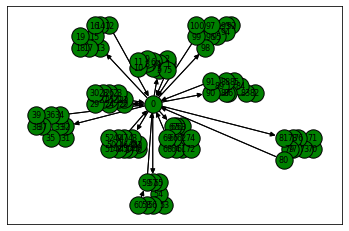

In [21]:
#file = "./Desktop/RO_progetto/Dataset/Solomon/25/C101.txt" # Nodi Clienti: 25, Veicoli: 25, Capacità: 200
file = "./Desktop/RO_progetto/Dataset/Solomon/100/C101.txt" # Nodi Clienti: 100, Veicoli: 25, Capacità: 200
#file = "./Desktop/RO_progetto/Dataset/Homberger/C1_2_1.TXT" # Nodi Clienti: 200, Veicoli: 50, Capacità: 200
#file = "./Desktop/RO_progetto/Dataset/Homberger/C1_4_1.TXT" # Nodi Clienti: 400, Veicoli: 100, Capacità: 200
#file = "./Desktop/RO_progetto/Dataset/Homberger/C1_6_1.TXT" # Nodi Clienti: 600, Veicoli: 150, Capacità: 200


#node = {"number": , "coordinate": , "demand": , "rdy_time": , "due_date": , "service_time": }
#problem = {"nodes_num":  , "nodes": , "name_instance": , "num_veh": , "capacity": , "d_matrix": , "t_matrix": , "routes": }
#solution = {"problem": , "routes": , "truck_count": , "obj_fun_value": , "admissible": , "fitness": }
#GA = {"problem":, "population": }


problem = read_file(file)
print_P(problem)


GA = {"problem": problem, "population": []}

popolazione = []
popolazione_new = []
k = 0
old_best = 100000000
val = 0

print("load", end="")
while k < 3:
    popolazione_new = []
    GA["population"] = []
    popolazione_new = starting_population_MDMD(GA, 50, 50)
    best = best_solution(GA)
    if(best["obj_fun_value"] < old_best):
        popolazione = []
        popolazione = popolazione_new[0:len(popolazione_new)]
        k = 0
        old_best = best["obj_fun_value"]
        val = best["obj_fun_value"]
    else:
        k += 1
    print("..", end='')
print("\nSoluzione euristica: ", val )


(dim_crossover, mut_prob, dim_mut) = parameter_calculation(file)
buff_list = []

print("Probabilità mutazione : ", dim_crossover, "|| Dimensione mutazione : ", mut_prob, "|| Dimensione crossover : ", dim_mut)

for k in range(3):
    GA["population"][0:len(popolazione)] = popolazione[0:len(popolazione)]
    best = GA_algorithm(GA, 750, mut_prob, dim_mut, dim_crossover)
    buff_list.append(best)
# Calcolo la migliore delle 3 soluzioni migliori
minimo = min(buff_list, key=lambda item: item["obj_fun_value"])

print("Veicoli utilizzati: ", minimo["truck_count"])
print("Soluzione migliore: ", minimo["obj_fun_value"])
print("Gap Ottenuto: ", gap_calculation(file, minimo["obj_fun_value"]), "%")
graph_solution(GA, minimo)





# ---------------------------------------------------------------------------------------------------------- Sperimentazione parametri ---------------------------------------------------------------------------------------------------------- #

#dim_crossover = [5, 10, 15, 20, 40]
#mut_prob = [0.001, 0.05, 0.1, 0.2]
#dim_mut = [3, 5, 10, 15]


#sol_list = []
#for c in dim_crossover:
#    for m in mut_prob:
#        for d_m in dim_mut:
#            buff_list = []
#            print("Probabilità mutazione : ", m, "|| Dimensione mutazione : ", d_m, "|| Dimensione crossover : ", c)
#            for k in range(3):
#                GA["population"][0:len(popolazione)] = popolazione[0:len(popolazione)]
#                best = GA_algorithm(GA, 750, m, d_m, c)
#                buff_list.append(best)
#            minimo = min(buff_list, key=lambda item: item["obj_fun_value"])
#            print("Soluzione migliore: ", minimo["obj_fun_value"])
#            sol_list.append(minimo)

#migliore = min(sol_list, key=lambda item: item["obj_fun_value"])
#print("Migliore soluzione trovata: ", migliore["obj_fun_value"])
#print("Gap Ottenuto: ", gap_calculation(file, migliore["obj_fun_value"]), "%")
#graph_solution(GA, migliore)

# Risultati e confronto

I seguenti sono i risultati ottenuti mediante l'algoritmo genetico e confrontati con il risulutore gurobi (per dataset piccoli) e le soluzioni ottime allegate ai siti del dataset (per dataset grandi).
I risultati riportati sono una media delle esecuzioni svolte


| **Dataset Name** | **Best Distances** | **GA Distances BCRC** | **GA Distances DC** | **Gap BCRC** | **Gap DC** | **Best Vehicle Number** | **GA Vehicle Number** | **Nodes Number** |
|:----------------:|:------------------:|:---------------------:|:-------------------:|:------------:|:----------:|:-----------------------:|:---------------------:|:----------------:|
|    **C101_25**   |        191,3       |         191,8         |        191,8        |     0,27%    |    0,27%   |            3            |           3           |        25        |
|   **C101_100**   |        827,3       |         828,9         |        852,9        |     0,19%    |    3,1%    |            10           |           10          |        100       |
|    **C1_2_1**    |       2707,9       |        3114,08        |       3486,05       |      15%     |   28,73%   |            20           |           20          |        200       |
|    **C1_4_1**    |       7152,02      |         9346,5        |        9888,4       |      31%     |    38,2%   |            40           |           41          |        400       |
|    **C1_6_1**    |      14095,64      |        17808,84       |       18601,99      |      26%     |    31,9%   |            60           |           65          |        600       |




# Riferimenti

- [1] Krzysztof Podlaski, Grzegorz Wiatrowski: Multi-objective optimization of vehicle routing problem using evolutionary algorithm with memory
- [2] Mohammad Sajid, Jagendra Singh, Raza Abbas Haidri, Mukesh Prasad, Vijayakumar Varadarajan, Ketan Kotecha and Deepak Garg: A Novel Algorithm for Capacitated Vehicle Routing Problem for Smart Cities